<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
 

<strong>Objectives:</strong>
+ Estudiar los missings en la variable uds venta
+ Discernir ceros (no venta) de verdaderos missings (datos faltantes)
    
    
<strong>Conclusions:</strong>
+ Hay datos faltantes correspondientes a los días 23, 24, 25 y 26
+ No podemos discernir entre una no venta y un valor perdido (por no apertura del negocio o por fallo del dato)
+ Hay 7 de 50 festivos con ventas, de momento se decide pasar esas ventas al día anterior.
+ Los días con más missings coinciden con días de baja demanda (sábados, días de verano) por lo que sustentan la teoría de reemplazar estos missings con zeros.

   
</div>

In [1]:
import os, sys

def get_root_path(search_word):
    """ Búsqueda hacia atrás de un directorio con nombre search_word. """
    cwd = os.getcwd()
    while str(os.getcwd()).split('/')[-1] != search_word:
        os.chdir("..")
        cwd = os.getcwd()
    return cwd

ROOT_DIR = get_root_path('TFM_StockForecast')

sys.path.insert(0, ROOT_DIR) # Poner en el primer lugar del PATH (evitar paquetes con mismos nombres en otros directorios)

In [2]:
import pandas as pd
from src.load_data import load_data

In [3]:
# PRINT EDA FOR STOCK DATA
df = load_data()

variable = "udsventa"

===================  LOAD DATASET stock ====================
Reading CSV in data/raw/03_TablaStock.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 628.
============  CLEAN STOCK  =============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). Rows dropped: 1784
[WARNING] Number of dates missings:                                83
[WARNING] Number of dates missings (droping sundays and festivos): 63
[WARNING] Stock data with different units for same product & data. Rows: 12666
Dataset stock loaded. Shape: (25518, 3)

===================  LOAD DATASET ventas ===================
Reading CSV in data/raw/01_TablaVentas.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 0.
============  CLEAN VENTAS  ============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). 

In [4]:
def filter_festivos(indf, only):
    df = indf.copy()
    if only:
        df = df.loc[(df.festivo == 1) | (df.weekday == 6)]
    else: 
        df = df.loc[(df.festivo != 1) & (df.weekday != 6)]
    return df
def perc(df1, df2):
    return round(100* df1.shape[0]/df2.shape[0])

In [5]:
# Declarar todos los df de estudio:

# ventas_byprod
ventas_byprod = pd.read_csv("data/clean/ventas_byprod.csv")


# df con registros con valores, con 0s y missings
exist = df.loc[~df[variable].isna()]
miss = df.loc[df[variable].isna()]
zeros = df.loc[df[variable] == 0]

# Missings sin contar las vacaciones
miss_noholiday = filter_festivos(miss, False)

# Missings por producto
byprod = miss_noholiday.groupby("producto")['fecha'].count().reset_index().sort_values("fecha", ascending=False)
byprod.columns = ["producto", "num_missings"]

# Missings por fecha
bydate = miss_noholiday.groupby("fecha")['producto'].count().reset_index().sort_values("producto", ascending=False)
bydate.columns = ["fecha", "num_missings"]

# Missings por dia de la semana
byday = miss.groupby("weekday")['producto'].count().reset_index().sort_values("producto", ascending=False)
byday.columns = ["weekday", "num_missings"]

# Analisis previo

In [6]:
print("Registros totales en dataset: {} ".format(df.shape[0]))
print("Productos totales: {} ".format(len(df.producto.unique())))
print("Días totales: {} ".format(len(df.fecha.unique())))
print("Dias totales de vacaciones: {} ".format(len(filter_festivos(df, True).fecha.unique())))

Registros totales en dataset: 21312 
Productos totales: 72 
Días totales: 296 
Dias totales de vacaciones: 50 


# Datos existentes en dias de vacaciones (festivos y domingos)

In [7]:
print("  Valores existentes en dias de vacaciones: {}"\
                .format(filter_festivos(exist, True).shape[0]))

print("  Dias de vacaciones con datos: {}"\
                .format(len(filter_festivos(exist, True).fecha.unique())))

filter_festivos(exist, True).fecha.unique()

  Valores existentes en dias de vacaciones: 252
  Dias de vacaciones con datos: 7


array(['2019-06-30T00:00:00.000000000', '2019-10-13T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-12-06T00:00:00.000000000',
       '2019-12-09T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2020-01-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [8]:
print("Dias festivos con datos:")
filter_festivos(exist, True).groupby("fecha")['producto'].count()

Dias festivos con datos:


fecha
2019-06-30    25
2019-10-13    26
2019-11-01    65
2019-12-06    44
2019-12-09    68
2020-01-01     7
2020-01-05    17
Name: producto, dtype: int64

¿Porqué tienen datos estos festivos?

# Datos perdidos en el total y sin contar las vacaciones

In [9]:
print("  Valores missings in udsventa:                                                              {} ({}%)"\
                .format(miss.shape[0], perc(miss, df)))

print("  Valores con ceros in udsventa:                                                             {} ({}%)"\
                .format(zeros.shape[0], perc(zeros, df)))

print("  Valores missings in udsventa sin domingos y festivos:                                      {} ({}%)"\
                .format(miss_noholiday.shape[0], perc(miss_noholiday, df)))

print("  Valores missings in udsventa sin domingos y festivos y con datos anteriores al 2020-03-23: {} ({}%)"\
                .format(miss_noholiday.loc[miss_noholiday.fecha < '2020-03-23'].shape[0], perc(miss_noholiday, df)))

  Valores missings in udsventa:                                                              5421 (25%)
  Valores con ceros in udsventa:                                                             26 (0%)
  Valores missings in udsventa sin domingos y festivos:                                      2073 (10%)
  Valores missings in udsventa sin domingos y festivos y con datos anteriores al 2020-03-23: 1785 (10%)


# Datos con ceros

In [10]:
zeros

,fecha,producto,udsstock,udsventa,udsprevisionempresa,promo,festivo,weekday
284,2019-06-08,96,NaN,0.0,251.0,1.0,0.0,5
8131,2019-09-25,95,26.0,0.0,545.0,0.0,0.0,2
10075,2019-10-22,95,NaN,0.0,0.0,0.0,0.0,1
13235,2019-12-05,84,NaN,0.0,1648.0,1.0,0.0,3
13290,2019-12-06,59,486.0,0.0,1451.0,0.0,1.0,4
17226,2020-01-30,29,NaN,0.0,3198.0,1.0,0.0,3
17586,2020-02-04,29,NaN,0.0,3559.0,0.0,0.0,1
17658,2020-02-05,29,NaN,0.0,7907.0,0.0,0.0,2
18018,2020-02-10,29,NaN,0.0,4661.0,0.0,0.0,0
18090,2020-02-11,29,NaN,0.0,3036.0,0.0,0.0,1


In [13]:
df.loc[(df.producto=="29") & (~df.udsventa.isna())]

,fecha,producto,udsstock,udsventa,udsprevisionempresa,promo,festivo,weekday
18,2019-06-05,29,2015.0,1343.0,24429.0,0.0,0.0,2
90,2019-06-06,29,NaN,1562.0,26456.0,0.0,0.0,3
162,2019-06-07,29,NaN,3330.0,29147.0,0.0,0.0,4
234,2019-06-08,29,NaN,82.0,1013.0,0.0,0.0,5
450,2019-06-11,29,864.0,2474.0,9006.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
19746,2020-03-05,29,NaN,0.0,0.0,0.0,0.0,3
20034,2020-03-09,29,NaN,0.0,0.0,0.0,0.0,0
20106,2020-03-10,29,NaN,0.0,0.0,0.0,0.0,1
20610,2020-03-17,29,NaN,0.0,0.0,0.0,0.0,1


# Datos perdidos por producto

In [14]:
print("   Missings en udsventa sin domingos y festivos para {} productos de {} totales."\
                .format(byprod.loc[byprod.num_missings != 0].shape[0], byprod.shape[0]))
print("   5 productos con más missings:")
byprod.head()

   Missings en udsventa sin domingos y festivos para 72 productos de 72 totales.
   5 productos con más missings:


,producto,num_missings
67,95,167
58,80,139
71,99,135
40,57,69
6,15,59


# Datos perdidos por fecha

In [19]:
print("   Missings en udsventa sin domingos y festivos para {} fechas de {} totales."\
                .format(bydate.loc[bydate.num_missings != 0].shape[0], bydate.shape[0]))
print("Dias sin ningun dato (de los no festivos):")
bydate.loc[bydate.num_missings == 72].sort_values("fecha")

   Missings en udsventa sin domingos y festivos para 219 fechas de 219 totales.
Dias sin ningun dato (de los no festivos):


,fecha,num_missings
32,2019-07-31,72
33,2019-08-01,72
34,2019-08-02,72
35,2019-08-03,72
50,2019-08-27,72
215,2020-03-23,72
216,2020-03-24,72
217,2020-03-25,72
218,2020-03-26,72


#### Los missings del 23 al 26 de marzo de 2020 son missings reales, los de verano es posible que no haya ventas.

In [20]:
print("   5 fechas con más missings (sin que sean todos):")
bydate.loc[bydate.num_missings !=72].head()

   5 fechas con más missings (sin que sean todos):


,fecha,num_missings
49,2019-08-26,68
88,2019-10-19,42
51,2019-08-28,35
36,2019-08-05,35
10,2019-06-22,27


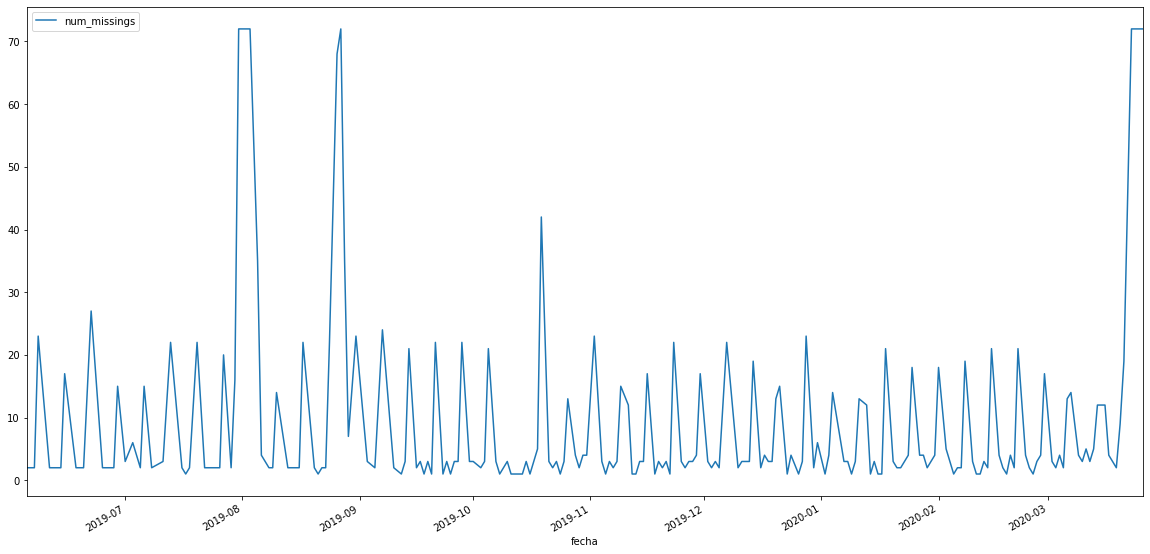

In [21]:
bydate.sort_values("fecha").set_index("fecha").plot(figsize=(20,10))

# Missings por dia de la semana (contando festivos)

In [22]:
byday.sort_values("weekday")

,weekday,num_missings
0,0,367
1,1,250
2,2,384
3,3,308
4,4,225
5,5,931
6,6,2956
